In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
dataset = pd.read_csv('dataset_NN.csv')
dataset.head()

,att1,att2,att3,att4,att5,att6,class
0,1.0,0.0,0.0,133.150861,1.311693,1620.221779,1
1,1.0,0.0,0.0,126.724861,1.302745,1609.334822,1
2,1.0,0.0,0.0,131.173861,1.319031,1568.978435,1
3,1.0,0.0,0.0,129.478861,1.270878,1695.055281,1
4,1.0,0.0,0.0,127.262861,1.329637,1647.720235,1


In [3]:
x = dataset.iloc[:,:-1].values    #feature attributes
y = dataset.iloc[:,-1:].values    #target attribute

In [4]:
def my_train_test_split(X, y, train_size):
    '''
    my own data splitting function
    '''
    arr_rand = np.random.rand(X.shape[0])
    split = arr_rand < np.percentile(arr_rand, train_size*100)

    X_Train = X[split]
    y_Train = y[split]
    X_Test =  X[~split]
    y_Test = y[~split]

    return X_Train, X_Test, y_Train, y_Test

def standardise_values(a):
    '''
    standardisation function, make data mean  = 0 and sd = 1
    '''
    mean = np.mean(a)
    sd = np.std(a)
    for i in range(len(a)):
        a[i] = (a[i]-mean)/sd
    return a

## Data Pre-processing

In [5]:
for i in range(len(x.T)):
    x.T[i] = standardise_values(x.T[i])

print(x[0],y[0])
print(x.shape)

[ 0.76340069 -1.51835049 -1.01989185 -0.93058101 -1.12578212 -1.20717246] [1]
(2000, 6)


In [6]:
#One Hot Encode y from (1400,1) to (1400,10)
def one_hot_encode(y):
    one_hot_y = np.zeros((y.shape[0],10))
    for i in range(y.shape[0]):
        one_hot_y[i][y[i] - 1] = 1

#     print(y[1000], one_hot_y[1000])
#     print(one_hot_y.shape)
    
    return one_hot_y

## Activations

In [7]:
def ReLU(x):
    return (abs(x.astype(float))+x.astype(float))/2

def ReLU_derivative(x):
    y=x
    np.piecewise(y,[ReLU(y)==0,ReLU(y)==y],[0,1])
    return y

def tanh(x):
    return np.tanh(x.astype(float))

def tanh_derivative(x):
    return 1-np.square(tanh(x))

def sigmoid(x):
    return 1/(1+np.exp(-x.astype(float)))

def sigmoid_derivative(x):
    return x*(1-x)

def softmax(A):
    expA = np.exp(A)
    out = expA / expA.sum(axis=1, keepdims=True)
    return out

## NeuralNetowork Class

In [25]:
class NeuralNetwork:
    def __init__(self, x, y, alpha, batch_size):
        self.input    = x
        self.weights1 = np.random.rand(self.input.shape[1], 30)    #first hidden layer has 30 nodes
        self.weights2 = np.random.rand(30, 20)                     #second hidden layer has 20 nodes
        self.weights3 = np.random.rand(20,10)                      #output layer has 10 nodes
        self.y        = y
        self.output   = np.zeros(y.shape)
        self.alpha    = alpha
        self.batch_size = batch_size

    
    def feedforward(self, x_mini):
        self.layer1 = tanh(np.dot(x_mini, self.weights1))
        self.layer2 = tanh(np.dot(self.layer1, self.weights2))
        self.output = sigmoid(np.dot(self.layer2, self.weights3))
    
    def create_mini_batches(self, X, y):
        mini_batches = []
        data = np.hstack((X, y))
        np.random.shuffle(data)
#         print("X variable's shape is = ",X.shape)
#         print("y variable's shape is = ",y.shape)
#         print("Data variable's shape is = ",data.shape)
        n_minibatches = data.shape[0] // self.batch_size
        
        i=0
        for i in range(n_minibatches):
            mini_batch = data[i * self.batch_size:(i + 1)*self.batch_size, :]
            X_mini = mini_batch[:, :-10]
            Y_mini = mini_batch[:, -10:]
            mini_batches.append((X_mini, Y_mini))
        if data.shape[0] % self.batch_size != 0:
            mini_batch = data[i * self.batch_size:data.shape[0]]
            X_mini = mini_batch[:, :-10]
            Y_mini = mini_batch[:, -10]
            mini_batches.append((X_mini, Y_mini))
        
        return mini_batches
        
        
    def backprop(self, x_mini, y_mini):
        m=len(self.input)
        
        dw3 = -(1/m) * np.dot(self.layer2.T, (y_mini - self.output))
        dw2 = -(1/m) * np.dot(self.layer1.T, (np.dot((y_mini -self.output), self.weights3.T) * tanh_derivative(self.layer2)))
        dw1 = -(1/m) * np.dot(x_mini.T, np.dot(np.dot( (y_mini -self.output), self.weights3.T) * tanh_derivative(self.layer2), self.weights2.T) * tanh_derivative(self.layer1))

        self.weights1 -= (self.alpha * dw1)
        self.weights2 -= (self.alpha * dw2)
        self.weights3 -= (self.alpha * dw3)

    
    def train(self):
        mini_batches = self.create_mini_batches(self.input, self.y)
        
        for mini_batch in mini_batches:
            x_mini, y_mini = mini_batch
#             print("X_mini shape = ",x_mini.shape)
#             print("Y_mini shape = ",y_mini.shape)
            self.feedforward(x_mini)
            self.backprop(x_mini, y_mini)


    def calc_loss(self):
        m=len(self.input)
        self.feedforward(self.input)
        loss = (1/m)*np.sum(np.square(self.y-self.output))
        return loss

    def CE_loss(self):
        self.feedforward(self.input)
        sig_output = softmax(self.output)
        loss_matrix = np.multiply(self.y, np.log(sig_output))
        loss = -np.sum(loss_matrix)
        return loss



    def predict(self,X):
        self.layert_1 = tanh(np.dot(X, self.weights1))
        self.layert_2 = tanh(np.dot(self.layert_1, self.weights2))
        return sigmoid(np.dot(self.layert_2, self.weights3))


In [26]:
def accuracy(y_pred, y_orig):
        total = len(y_pred)
        correct = 0
        for i in range(total):
#             print(y_pred[i], y_orig[i])
            if y_pred[i] == y_orig[i]:
                correct = correct + 1
        return (correct / total)  * 100

## Creating and training the NN

In [27]:
X_train, X_test, y_train, y_test = my_train_test_split(x, y, 0.7)
one_hot_y_train = one_hot_encode(y_train)
one_hot_y_test = one_hot_encode(y_test)

loss_list = []
accuracy_list = []
iter_list = []
NN = NeuralNetwork(X_train, one_hot_y_train, 0.1, 100)
print("Weights1 size = ",NN.weights1.shape)
print("Weights2 size = ",NN.weights2.shape)
print("Weights3 size = ",NN.weights3.shape)
print("Output shape = ",NN.output.shape)
iterations = 3000

for i in range(iterations):
    NN.train()
    if i % 100 == 0: 
        print ("for iteration # " + str(i) + "\n")
        iter_list.append(i)
        loss = NN.calc_loss()
        loss_list.append(loss)
        print ("Loss: " + str(loss)) # mean sum squared loss

        print ("Cross Entropy Loss: " + str(NN.CE_loss()))
        y_predict_train = NN.output
        output_train = (np.argmax(y_predict_train, axis = 1) + 1).reshape(y_predict_train.shape[0],1)
        train_accuracy = accuracy(output_train, y_train)
        accuracy_list.append(train_accuracy)
        print ("Accuracy: " + str(train_accuracy))
        print ("\n")

print(NN.output.shape)

NN.feedforward(X_train)
y_predict_train = NN.output
output_train = (np.argmax(y_predict_train, axis = 1) + 1).reshape(y_predict_train.shape[0],1)
y_predict_test = NN.predict(X_test)
output_test = (np.argmax(y_predict_test, axis = 1) + 1).reshape(y_predict_test.shape[0],1)



train_accuracy = accuracy(output_train, y_train)
test_accuracy = accuracy(output_test, y_test)
cost = NN.calc_loss()

#----------------Displaying Final Metrics--------------------------#
print("MSE_Cost: {} , Train_Accuracy: {} , Test_Accuracy: {} ".format(cost,train_accuracy,test_accuracy))

Weights1 size =  (6, 30)
Weights2 size =  (30, 20)
Weights3 size =  (20, 10)
Output shape =  (1400, 10)
for iteration # 0

Loss: 4.963129925929696
Cross Entropy Loss: 3219.9314217241827
Accuracy: 8.071428571428571


for iteration # 100

Loss: 0.7782954288350045
Cross Entropy Loss: 2838.017703044712
Accuracy: 65.5


for iteration # 200

Loss: 0.5656390073173514
Cross Entropy Loss: 2740.6222780528415
Accuracy: 67.21428571428572


for iteration # 300

Loss: 0.48917172394003844
Cross Entropy Loss: 2686.764572321002
Accuracy: 67.92857142857143


for iteration # 400

Loss: 0.4758096413706801
Cross Entropy Loss: 2660.7034524800506
Accuracy: 69.21428571428572


for iteration # 500

Loss: 0.47517868615539977
Cross Entropy Loss: 2627.908498603494
Accuracy: 69.92857142857143


for iteration # 600

Loss: 0.479096047122352
Cross Entropy Loss: 2623.6398041037005
Accuracy: 70.57142857142857


for iteration # 700

Loss: 0.43670615281358593
Cross Entropy Loss: 2592.169010933082
Accuracy: 70.78571428571

## Plots

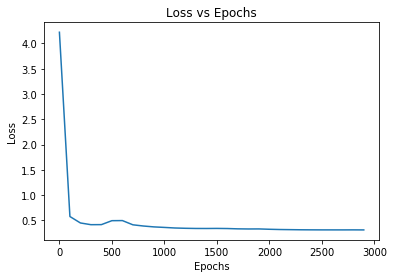

In [23]:
plt.plot(iter_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

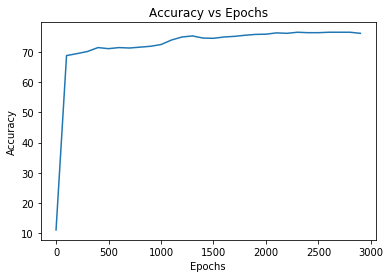

In [24]:
plt.plot(iter_list, accuracy_list)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()